# Probable Maximum Precipitation (PMP) module

This example shows how to use the PMP module to compute the Probable Maximum Precipitation from climate change scenarios.  This module allows to compute the PMP on a grid (distributed) and for aggregated values of precipitation following the methodology shown by Clavet-Gaumont et al. (2017).

In [1]:
from pathlib import Path
from zipfile import ZipFile

import pooch
import xarray as xr

from xhydro import pmp

## Open data 

This example uses a sample of 5-years and 2x2 grid cells from the CMIP model which can be accessed from the xhydro-testdata repository.

In [2]:
GITHUB_URL = "https://github.com/hydrologie/xhydro-testdata"
BRANCH_OR_COMMIT_HASH = "61e3b2b9a224d4dcc098c0acf3326cb13e22f441"

path_day_zip = pooch.retrieve(
    url=f"{GITHUB_URL}/raw/{BRANCH_OR_COMMIT_HASH}/data/pmp/CMIP.CCCma.CanESM5.historical.r1i1p1f1.day.gn.zarr.zip",
    known_hash="md5:191cffe11cacc303db697aa91d9be7ab",
)

path_fx_zip = pooch.retrieve(
    url=f"{GITHUB_URL}/raw/{BRANCH_OR_COMMIT_HASH}/data/pmp/CMIP.CCCma.CanESM5.historical.r1i1p1f1.fx.gn.zarr.zip",
    known_hash="md5:1257973a6f6047e6998c3430e3342534",
)

directory_to_extract_to_day = Path(
    path_day_zip
).parent  # To extract to the same directory as the zip file
with ZipFile(path_day_zip, "r") as zip_ref:
    zip_ref.extractall(directory_to_extract_to_day)

directory_to_extract_to_fx = Path(
    path_fx_zip
).parent  # To extract to the same directory as the zip file
with ZipFile(path_fx_zip, "r") as zip_ref:
    zip_ref.extractall(directory_to_extract_to_fx)

path_day_zarr = (
    str(directory_to_extract_to_day)
    + "/CMIP.CCCma.CanESM5.historical.r1i1p1f1.day.gn.zarr"
)
path_fx_zarr = (
    str(directory_to_extract_to_fx)
    + "/CMIP.CCCma.CanESM5.historical.r1i1p1f1.fx.gn.zarr"
)

For this example, the CMIP simulations on an daily scale  were used since it contains the variables necessary for the computing of the PMP:

ds_day
* pr --> Precipitation_flux  
* snw --> Snow water equivalent  
* hus --> Specific humidity 
* zg --> Geopotential height

ds_fx
* orog --> Surface altitude

In [3]:
ds_day = xr.open_zarr(path_day_zarr)
ds_fx = xr.open_zarr(path_fx_zarr)

In [42]:
path = "C:\\Users\\ospin\\OneDrive\\Documents\\CMP\\Data\\Bigger_domain\\"
ds_day2 = xr.open_zarr(path + "CMIP.CCCma.CanESM5.historical.r1i1p1f1.day.gn.zarr")[
    :, :, :7, :6
]
ds_fx2 = xr.open_zarr(path + "CMIP.CCCma.CanESM5.historical.r1i1p1f1.fx.gn.zarr")[
    :, :7, :6
]

KeyError: "No variable named (slice(None, None, None), slice(None, None, None), slice(None, 7, None), slice(None, 6, None)). Variables on the dataset include ['height', 'hus', 'lat_bounds', 'lon_bounds', 'plev', ..., 'time', 'time_bounds', 'x', 'y', 'zg']"

## 1. PMP distributed

### 1.1. Major precipitations events (pe).

Sum of precipitation over 1, 2, 3 and 4 days and retention of the year's most intense storms.

The 10% most intense storms are retained to avoid overmaximizing small precipitation events.

In [5]:
pe = pmp.major_precipitation_events(ds_day.rf, windows=[1, 2, 3, 4], quantile=0.9)

In [43]:
pe2 = pmp.major_precipitation_events(ds_day2.rf, windows=[1, 2, 3, 4], quantile=0.9)[
    :,
    :,
    :7,
    :6,
]

In [7]:
import numpy as np

### 2.2 Calculating daily precipitable water (pw)

Integration of specific humidity for all pressure levels for 1, 2, 3 and 4 days. Then, only the pw values associated with the major precipitation events (pe) are selected.


In [45]:
pw = pmp.precipitable_water(
    ds_day.hus,
    ds_day.zg,
    ds_fx.orog,
    windows=[1, 2, 3, 4],
    add_pre_lay=False,
)
pw_events = pw.where(pe > 0)[
    :,
    :,
    :7,
    :6,
]

In [46]:
pw2 = pmp.precipitable_water(
    ds_day2.hus,
    ds_day2.zg,
    ds_fx2.orog,
    windows=[1, 2, 3, 4],
    beta_func=True,
    add_pre_lay=False,
)
pw_events2 = pw2.where(pe > 0)[
    :,
    :,
    :7,
    :6,
]

###  2.3. Monthly 100-year return value of precipitable water (pw100)

According to Clavet-Gaumont et al. (2017), the pw100 is calculated using the Generalized Extreme Value (GEV) and limiting the maximum value for PW100 to be less than 20% larger than the largest value of the maximum PW values (mf=0.2).

In [10]:
pw100 = pmp.precipitable_water_100y(
    pw.sel(window=1).chunk(dict(time=-1)), dist="genextreme", method="ML", mf=0.2
)

In [48]:
pw1002 = pmp.precipitable_water_100y(
    pw2.sel(window=1).chunk(dict(time=-1)), dist="genextreme", method="ML", mf=0.2
)[
    :,
    :7,
    :6,
]

### 2.4.  Maximization ratio (r) and Maximized rainfall (pmax)

In [12]:
r = pw100 / pw_events
pmax = r * pe

In [13]:
r2 = pw1002 / pw_events2
pmax2 = r2 * pe2

### 2.5. Definition of seasons

1) The start and end of winter consider a minimum number of days with snow of 14 and 90 days, respectively, to guarantee snow accumulation at the beginning of winter and that there is no thaw at the end.

2) The start and end of spring are defined 60 days before and 30 days after the end of winter.

In [14]:
f = pmax.values

In [15]:
f[~np.isnan(f)]

array([20.40723407, 32.31036881, 29.50026897, ..., 50.34464438,
       50.38879288, 53.80385345])

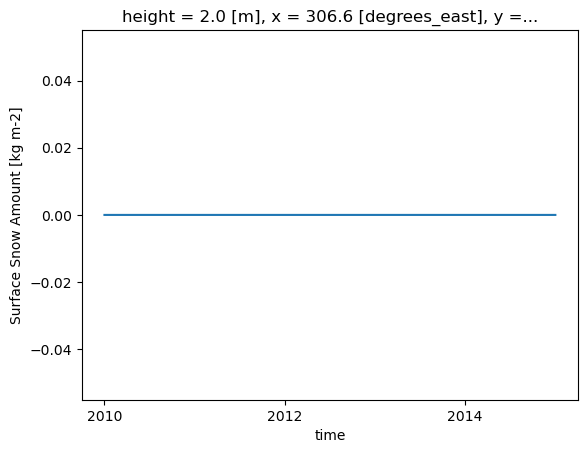

In [16]:
# ds_day.snw[:,0,0].plot()
# ds_day2.snw[:,5,5].plot()
ds_day2.snw[:, 8, 15].plot()

In [17]:
from copy import deepcopy

import xclim

In [18]:
snw = ds_day.snw
snw2 = ds_day2.snw
thresh = "1 cm"
window_wint_start = 14
window_wint_end = 14
spr_start = 60
spr_end = 30
freq = "YS-SEP"

In [19]:
attrs = deepcopy(snw.attrs)
snw = xclim.core.units.convert_units_to(snw, "mm", context="hydro")
# xclim expects precipitation and thus writes wrong attributes.
snw.attrs.update(attrs)
snw.attrs["units"] = "mm"

snw2 = xclim.core.units.convert_units_to(snw2, "mm", context="hydro")
# xclim expects precipitation and thus writes wrong attributes.
snw2.attrs.update(attrs)
snw2.attrs["units"] = "mm"

In [20]:
winter_start = xclim.indices.snd_season_start(
    snd=snw, thresh=thresh, window=window_wint_start, freq=freq
)

In [21]:
winter_start.values

array([[[  1.,   1.],
        [  1.,   1.]],

       [[319., 318.],
        [316., 314.]],

       [[302., 302.],
        [300., 299.]],

       [[303., 303.],
        [309., 304.]],

       [[322., 299.],
        [319., 301.]],

       [[303., 304.],
        [288., 288.]]])

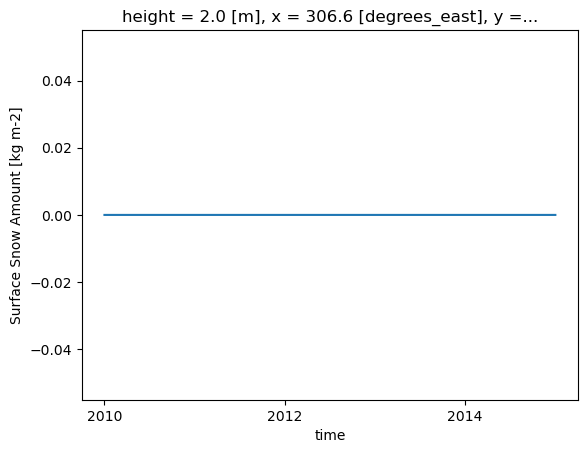

In [22]:
ds_day2.snw[:, 8, 15].plot()

In [23]:
xclim.indices.snd_season_start(
    snd=snw2[:, 0, 0], thresh=thresh, window=window_wint_start, freq=freq
).values

array([ 45., 324., 365.,  13., 345.,  nan])

In [34]:
xclim.indices.snd_season_start(
    snd=snw2, thresh=thresh, window=window_wint_start, freq=freq
).values[:, :7, :6]

array([[[ 45.,  45.,  45.,  45.,  12.,  45.],
        [  1.,   1.,  14.,  29.,  12.,   1.],
        [  1.,   1.,   1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.,  nan,  nan]],

       [[324., 323.,  nan,  nan,  31.,  15.],
        [  4.,   4., 331.,   6.,  13.,  12.],
        [339., 363.,   4.,   5.,   5.,   6.],
        [356., 349., 357., 363., 354., 347.],
        [ 17., 350., 335., 357., 343., 320.],
        [314., 320., 315., 297., 320., 331.],
        [305., 307., 307., 304.,  nan,  nan]],

       [[365., 364., 365.,   4.,   4., 364.],
        [342., 343., 343., 362.,   5.,   4.],
        [323., 323., 339., 343., 343., 348.],
        [325., 325., 324., 341., 344., 343.],
        [347., 338., 332., 333., 328., 325.],
        [307., 315., 294., 294., 320., 329.],
        [286., 288., 290., 298.,  nan,  nan]],

       [[ 13.,  nan,  nan,  

In [25]:
mask = pmp.compute_spring_and_summer_mask(
    ds_day.snw,
    thresh="1 cm",
    window_wint_start=14,
    window_wint_end=14,
    spr_start=60,
    spr_end=30,
    freq="YS-SEP",
)

pmax_spring = (pmax * mask.mask_spring).rename("pmp_spring")
pmax_summer = (pmax * mask.mask_summer).rename("pmp_summer")

In [26]:
mask2 = pmp.compute_spring_and_summer_mask(
    ds_day2.snw,
    thresh="1 cm",
    window_wint_start=14,
    window_wint_end=14,
    spr_start=60,
    spr_end=30,
    freq="YS-SEP",
)

pmax_spring2 = (pmax2 * mask2.mask_spring).rename("pmp_spring")
pmax_summer2 = (pmax2 * mask2.mask_summer).rename("pmp_summer")

ValueError: Winter never starts. Check the snow thickness, `freq` or `window` parameters.

### 2.6. PMP

In [ ]:
pmp_spring = pmax_spring.max("time")
pmp_summer = pmax_summer.max("time")

## 2. PMP with aggregated storm configurations

The spatial_average_storm_configurations function allows to spatially aggregate the storms following the different configurations shown in Clavet-Gaumont et al. (2017). Once aggregated, the calculation of the aggregated PMP follows the same steps shown above.

In [143]:
test = (
    pmp.spatial_average_storm_configurations(ds_day.rf, 10)
    .chunk(dict(time=-1))
    .compute()
)

In [144]:
test

<xarray.Dataset> Size: 38MB
Dimensions:  (y: 9, x: 16, time: 1825)
Coordinates:
  * y        (y) float64 72B 40.46 43.25 46.04 48.84 ... 54.42 57.21 60.0 62.79
  * x        (x) float64 128B 264.4 267.2 270.0 272.8 ... 300.9 303.8 306.6
  * time     (time) object 15kB 2010-01-01 12:00:00 ... 2014-12-31 12:00:00
    height   float64 8B 2.0
Data variables: (12/18)
    2        (time, y, x) float64 2MB nan nan nan nan nan ... nan nan nan nan
    3        (time, y, x) float64 2MB nan nan nan nan nan ... nan nan nan nan
    4        (time, y, x) float64 2MB nan nan nan nan nan ... nan nan nan nan
    5.a      (time, y, x) float64 2MB nan nan nan nan nan ... nan nan nan nan
    5.b      (time, y, x) float64 2MB nan nan nan nan nan ... nan nan nan nan
    6        (time, y, x) float64 2MB nan nan nan nan nan ... nan nan nan nan
    ...       ...
    16       (time, y, x) float64 2MB nan nan nan nan nan ... nan nan nan nan
    18       (time, y, x) float64 2MB nan nan nan nan nan ... nan nan nan nan
    20       (time, y, x) float64 2MB nan nan nan nan nan ... nan nan nan nan
    23       (time, y, x) float64 2MB nan nan nan nan nan ... nan nan nan nan
    24       (time, y, x) float64 2MB nan nan nan nan nan ... nan nan nan nan
    25       (time, y, x) float64 2MB nan nan nan nan nan ... nan nan nan nan

In [28]:
ds_day.rf

<xarray.DataArray 'rf' (time: 1825, y: 2, x: 2)> Size: 58kB
dask.array<open_dataset-rf, shape=(1825, 2, 2), dtype=float64, chunksize=(1825, 2, 2), chunktype=numpy.ndarray>
Coordinates:
    height   float64 8B ...
  * time     (time) object 15kB 2010-01-01 12:00:00 ... 2014-12-31 12:00:00
  * x        (x) float64 16B 286.9 289.7
  * y        (y) float64 16B 51.63 54.42

In [32]:
ds_day2.y

<xarray.DataArray 'y' (y: 9)> Size: 72B
array([40.46, 43.25, 46.04, 48.84, 51.63, 54.42, 57.21, 60.  , 62.79])
Coordinates:
    height   float64 8B ...
  * y        (y) float64 72B 40.46 43.25 46.04 48.84 ... 54.42 57.21 60.0 62.79
Attributes:
    axis:           Y
    bounds:         lat_bnds
    long_name:      Latitude
    standard_name:  latitude
    units:          degrees_north

In [2]:
test = pmp.spatial_average_storm_configurations(ds_day2.rf, 5).chunk(dict(time=-1))

NameError: name 'pmp' is not defined

In [1]:
test

NameError: name 'test' is not defined

In [61]:
ds_day2.rf[0, :, :].values

array([[ 8.36841355e-04,  7.78036710e-07,  0.00000000e+00,
         7.85803422e-08,  5.28683356e-01,  1.23628881e-01,
         1.59200701e+00,  9.37877569e+00,  4.32980546e+00,
         1.97395140e+00,  2.59712652e+00,  2.11130748e+00,
         2.44574538e-01,  7.40878648e-01,  1.37360481e+00,
         2.36726330e+00],
       [ 2.18544191e-05,  3.92901711e-08,  5.93556615e-03,
         5.69707481e-07,  5.80501277e-02,  1.01194193e-02,
         1.24806172e-01,  7.74309201e+00,  3.00836104e+01,
         1.53676344e+01,  5.35930695e+00,  4.63115133e+00,
         7.43102314e-01,  4.55821227e-01,  7.17662871e-01,
         1.22113164e-01],
       [ 9.42964107e-07,  9.82254278e-07,  1.61089702e-06,
         7.07223080e-07,  4.21387085e-06,  7.88003672e-04,
         1.19510014e-01,  2.57699360e+00,  1.69836349e+01,
         2.84324372e+01,  2.17087235e+01,  3.81905618e+00,
         2.09099745e+00,  6.15418413e-01,  1.76311201e+00,
         2.03159479e+00],
       [ 8.54561222e-07,  9.42964107e

In [68]:
ds_day_agg = pmp.spatial_average_storm_configurations(ds_day2.rf, 10).chunk(
    dict(time=-1)
)
pe_agg = pmp.major_precipitation_events(
    ds_day_agg.chunk(dict(conf=-1)), windows=[1, 2, 3, 4], quantile=0.9
)

# Precipitable water (pw) must first be calculated in a distributed manner and then spatially averaged to obtain the aggregated precipitable water.
pw_agg = pmp.spatial_average_storm_configurations(pw2, 10)

pw_events_agg = pw_agg.where(pe_agg > 0)

pw100_agg = pmp.precipitable_water_100y(
    pw_agg.sel(window=1).chunk(dict(time=-1)), dist="genextreme", method="ML", mf=0.2
)

r_agg = pw100_agg / pw_events_agg

pmax_agg = r_agg * pe_agg

# To create the spring and summer masks, the snow cover must first be spatially averaged (ds_snw_agg).
ds_snw_agg = pmp.spatial_average_storm_configurations(ds_day2.snw, 10).chunk(
    dict(time=-1)
)
mask_agg = pmp.compute_spring_and_summer_mask(
    ds_snw_agg,
    thresh="1 cm",
    window_wint_start=14,
    window_wint_end=90,
    spr_start=60,
    spr_end=30,
    freq="YS-SEP",
)

pmax_spring_agg = (pmax_agg * mask_agg.mask_spring).rename("pmp_spring")
pmax_summer_agg = (pmax_agg * mask_agg.mask_summer).rename("pmp_summer")

pmp_spring_agg = pmax_spring_agg.max("time")
pmp_summer_agg = pmax_summer_agg.max("time")

ValueError: chunks keys ('conf',) not found in data dimensions ('y', 'x', 'time')

## Results

In [17]:
pmp_spring_agg.sel(window=2).values

array([60.67189571, 72.63945754, 67.84400322, 78.85401712, 56.29421056,
       63.72309807, 71.3476229 , 56.71860845, 59.69289372, 54.32798932,
       67.09802145, 68.25585291, 55.24401929])

In [18]:
pmp_spring.sel(window=2).values

array([[60.67190138, 72.63939131],
       [67.8435789 , 78.85402027]])

In [19]:
pmp_summer_agg.sel(window=2).values

array([132.14188068,  97.21404256, 113.25224049, 109.40163951,
       104.4918091 , 102.05763955,  80.5686025 ,  79.48844908,
        98.31740742,  94.42134807,  88.28404279,  81.08263708,
        78.04052048])

In [20]:
pmp_summer.sel(window=2).values

array([[132.1361102 ,  97.21404401],
       [113.25224197, 109.40164093]])

In [20]:
import warnings
from itertools import product

import numpy as np

In [64]:
npy_confi = np.abs(max(conf_y)) + np.abs(min(conf_y)) + 1
npy_confi

3

In [92]:
# da = ds_day.rf
# radius = 10

# dict_config = {
# "1": [[0], [0]],
# "2": [[0, 0], [0, 1]],
# "3": [[0, 0, -1], [0, 1, 0]],
#  "4": [[0, 0, -1, -1], [0, 1, 0, 1]],
# "5.a": [[0, 0, -1, -1, 0], [0, 1, 0, 1, -1]],
# "5.b": [[0, 0, -1, -1, -1], [0, 1, -1, 0, 1]],
# "6": [[0, 0, 0, 1, 1, 1], [0, 1, -1, 0, 1, -1]],
# "7": [[0, 0, 0, -1, -1, -1, 1], [0, 1, -1, 0, 1, -1, 0]],
# "8": [[0, 0, 0, -1, -1, -1, 1, 1], [0, 1, -1, 0, 1, -1, 0, 1]],
# "9": [[0, 0, 0, -1, -1, -1, 1, 1, 1], [0, 1, -1, 0, 1, -1, 0, 1, -1]],
# "10": [[0, 0, 0, 0, -1, -1, -1, -1, 1, 1], [-1, 0, 1, 2, -1, 0, 1, 2, 0, 1]],
# "12": [
#     [0, 0, 0, 0, -1, -1, -1, -1, 1, 1, 1, 1],
#     [-1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2],
# ],
# "14": [
#     [0, 0, 0, 0, -1, -1, -1, -1, 1, 1, 1, 1, 2, 2],
#     [-1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2, 0, 1],
# ],
# "16": [
#     [0, 0, 0, 0, -1, -1, -1, -1, 1, 1, 1, 1, 2, 2, 2, 2],
#     [-1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2],
# ],
# "18": [
#     [0, 0, 0, 0, -2, -2, -2, -2, -1, -1, -1, -1, 1, 1, 1, 1, 2, 2],
#     [-1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2, 0, 1],
# ],
# "20": [
#     [0, 0, 0, 0, -2, -2, -2, -2, -1, -1, -1, -1, 1, 1, 1, 1, 2, 2, 2, 2],
#     [-1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2],
# ],
# '23': [[-2,-2,-2,-2,-2,-1,-1,-1,-1,-1,0,0,0,0,0,1,1,1,1,1,2,2,2],
#         [-2,-1,0,1,2,-2,-1,0,1,2,-2,-1,0,1,2,-2,-1,0,1,2,-1,0,1]
# ],
# '24': [[-2,-2,-2,-2,-1,-1,-1,-1,0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3],
#             [-1,0,1,2,-1,0,1,2,-1,0,1,2,-1,0,1,2,-1,0,1,2,-1,0,1,2]
# ],
# '25': [[-2,-2,-2,-2,-2,-1,-1,-1,-1,-1,0,0,0,0,0,1,1,1,1,1,2,2,2,2,2],
#         [-2,-1,0,1,2,-2,-1,0,1,2,-2,-1,0,1,2,-2,-1,0,1,2,-2,-1,0,1,2]
# ],
# }


# x = da.cf.axes["X"][0]
# y = da.cf.axes["Y"][0]

# # Pixel size
# dy = (da[y][1] - da[y][0]).values
# dx = (da[x][1] - da[x][0]).values

# # Number of pixels in da
# npy_da = len(da[y])
# npx_da = len(da[x])

# da_stacked = da.stack(stacked_coords=("y", "x"))
# confi_ds = xr.Dataset()
# for name, confi in dict_config.items():

#     conf_y = confi[0]
#     conf_x = confi[1]

#     # Number of pixels in the configuration
#     npy_confi = np.abs(max(conf_y)) + np.abs(min(conf_y)) + 1
#     npx_confi = np.abs(max(conf_x)) + np.abs(min(conf_x)) + 1

#     # Checks that the configuration size is within the desired storn size.
#     if (dy * npy_confi / 2 > radius) or (dx * npx_confi / 2 > radius):
#         break

#     # Checks that the configuration fits in the domain.
#     if (npy_confi > npy_da) or (npx_confi > npx_da):
#         break

#     # Number of times a configuration can be shifted in each axis
#     ny = len(da[y]) - npy_confi + 1
#     nx = len(da[x]) - npx_confi + 1

#     # List with the configuration duplicated as many times as indicated by nx and nx.
#     conf_y_ex = np.reshape(np.array(conf_y * ny), (ny, len(conf_y)))
#     conf_x_ex = np.reshape(np.array(conf_x * nx), (nx, len(conf_x)))

#     # List with the incrementes from 0 to nx and ny
#     inc_y = np.ones(conf_y_ex.shape) * [[i] for i in range(ny)]
#     inc_x = np.ones(conf_x_ex.shape) * [[i] for i in range(nx)]

#     # Shifted configurations
#     pos_y = (conf_y_ex + inc_y).astype(int)
#     pos_x = (conf_x_ex + inc_x).astype(int)

#     # Drop shifted configuration that are out of the domain
#     pos_y = pos_y[~np.any(pos_y < 0, axis=(1))]
#     pos_x = pos_x[~np.any(pos_x < 0, axis=(1))]

#     # List of all the combinations of the shifted configurations
#     shifted_confi = list(product(pos_y, pos_x))

#     # Center of the configuration
#     cen_conf = np.where((np.array(conf_y)==0)&(np.array(conf_x)==0))[0][0]

#     list_conf = []
#     for confi_shifted in shifted_confi:
#         matrix_mask = np.full((len(da[y]), len(da[x])), np.nan)

#         shift_y = confi_shifted[0]
#         shift_x = confi_shifted[1]

#         matrix_mask[(shift_y, shift_x)] = 1

#         cen_shift_y = shift_y[cen_conf]
#         cen_shift_x = shift_x[cen_conf]

#         list_rot = []
#         for rot in range(4):
#             matrix_mask_rot = _rotate_around_center(matrix_mask, (cen_shift_y, cen_shift_x), k=rot)

#             if np.sum(~np.isnan(matrix_mask_rot)) != np.shape(confi_shifted[0]): # Include nan to mask the cases when the configuration is out of the domain.
#                 matrix_mask_rot[:,:] = np.nan

#             da_mask = da * matrix_mask_rot

#             list_rot.append(
#                 da_mask.mean(dim=["x", "y"]).expand_dims(
#                     dim={"conf": [name + "_" + str(rot)]}
#                 )
#             )

#         rot_concat = xr.concat(list_rot, dim="conf").max(dim="conf", skipna=False).expand_dims(
#                         dim={"y": [da.y[cen_shift_y]], "x":[da.x[cen_shift_x]]}
#                     ).stack(stacked_coords=("y", "x"))

#         list_conf.append(rot_concat)

#     confi_ds[name] = xr.concat(list_conf, dim="stacked_coords").reindex_like(da_stacked, fill_value=np.nan)

# confi_ds = confi_ds.squeeze().unstack('stacked_coords')

In [93]:
confi_ds.compute()

<xarray.Dataset> Size: 8MB
Dimensions:  (y: 9, x: 16, time: 1825)
Coordinates:
  * y        (y) float64 72B 40.46 43.25 46.04 48.84 ... 54.42 57.21 60.0 62.79
  * x        (x) float64 128B 264.4 267.2 270.0 272.8 ... 300.9 303.8 306.6
    height   float64 8B 2.0
  * time     (time) object 15kB 2010-01-01 12:00:00 ... 2014-12-31 12:00:00
Data variables:
    1        (time, y, x) float64 2MB 3.008e+31 2.796e+28 ... 2.915e+34
    2        (time, y, x) float64 2MB nan nan nan nan nan ... nan nan nan nan
    3        (time, y, x) float64 2MB nan nan nan nan nan ... nan nan nan nan
    4        (time, y, x) float64 2MB nan nan nan nan nan ... nan nan nan nan

In [42]:
npy_confi > npy_da) or (npx_confi > npx_da):

array([[ 1., nan],
       [ 1., nan]])

In [54]:
npy_confi

2

In [53]:
npx_da

2

In [41]:
confi_ds["2"].compute()

<xarray.DataArray '2' (time: 1825, y: 2, x: 2)> Size: 58kB
array([[[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       ...,

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]]])
Coordinates:
  * y        (y) float64 16B 51.63 54.42
  * x        (x) float64 16B 286.9 289.7
  * time     (time) object 15kB 2010-01-01 12:00:00 ... 2014-12-31 12:00:00
    height   float64 8B 2.0

In [16]:
def _rotate_around_center(matrix, center, k=1):
    """
    Rotate a matrix around a given center point by 90 degrees k times.

    Parameters
    ----------
    matrix : array_like
        2D numpy array to be rotated.
    center: Tuple
        (row, col) indicating the center of rotation.
    k : int
        Number of 90-degree rotations.

    Returns
    -------
    array_like
        Rotated 2D numpy array.
    """

    def _rotate_point_k_times(py, px, cy, cx, k):
        """
        Rotate a point (px, py) by 90 degrees around a center point (cx, cy) for k times.

        Parameters
        ----------

        py : float
            y-coordinate of the point to be rotated.
        px : float
            x-coordinate of the point to be rotated.
        cy : float
            y-coordinate of the center of rotation.
        cx : float
            x-coordinate of the center of rotation.
        k : int
            Number of 90-degree rotations.

        Returns:
        -------
        Tuple
            New coordinates of the point after rotation.
        """
        # Normalize n to be within [0, 3] to avoid unnecessary rotations
        k = k % 4

        # Translate point to origin (subtract the center coordinates)
        translated_x = px - cx
        translated_y = py - cy

        # Rotate point k times
        for _ in range(k):
            translated_x, translated_y = -translated_y, translated_x

        # Translate point back to original coordinates
        final_x = translated_x + cx
        final_y = translated_y + cy

        return (final_y, final_x)

    matrix = np.array(matrix)
    rows, cols = matrix.shape
    rotated_matrix = np.full_like(matrix, np.nan)

    center_row, center_col = center

    for r in range(rows):
        for c in range(cols):
            if not np.isnan(matrix[r, c]):
                new_r, new_c = _rotate_point_k_times(r, c, center_row, center_col, k)
                if 0 <= new_r < rows and 0 <= new_c < cols:
                    rotated_matrix[new_r, new_c] = matrix[r, c]

    return rotated_matrix